# Spectral Analysis and Prediction Network
This jupyter notebook implements a comprehensive workflow for reading, preprocessing, training, and evaluating a neural network on raman spectral data for pigment composition. 

In [42]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Data preparation

A collection of CSV files containing spectral data is prepared for machine learning analysis. The script reads each CSV file in a specified directory, assuming the first column contains wavenumber values and the second column contains intensity values. It extracts concentration values from the filenames to use as labels. The data is then trimmed to include only wavenumbers up to 1800. Each spectrum is normalized by dividing by its sum to ensure the data is on a comparable scale. The normalized data is further standardized using the StandardScaler to ensure that each feature has a mean of zero and a standard deviation of one. Finally, the preprocessed data (features) and the extracted labels are prepared and stored in variables X and y, respectively.

In [43]:
# Path to the folder containing the .csv files
folder_path = 'data/csv-clean-renamed'  

# Read the data
wavenumbers = []
data = []
labels = []

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        filepath = os.path.join(folder_path, filename)
        spectrum = pd.read_csv(filepath, delimiter=',', header=None)
        wavenumbers.append(spectrum[0].values)  # Assuming first column is wavelength
        data.append(spectrum[1].values)  # Assuming second column is intensity
        # Extract concentration from filename
        concentration = float(filename.split('_')[0].replace('conc-', ''))
        labels.append(concentration)

wavenumbers = np.array(wavenumbers)
data = np.array(data)
labels = np.array(labels)

max_wavenumber = 1800
index_max_1500 = np.where(wavenumbers[0] <= max_wavenumber)[0][-1]
wavenumbers_trimmed = wavenumbers[0][:index_max_1500 + 1]
data_trimmed = data[:, :index_max_1500 + 1]
data_normalized = np.array([spectrum / np.sum(spectrum) for spectrum in data_trimmed])

# Standard scaling
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_normalized)

X = data_normalized
y = labels

# Custom dataset class

Define a custom dataset class called SpectraDataset for use with PyTorch.The dataset and is designed to handle the preprocessed spectral data and corresponding labels. In the __init__ method, the class takes the feature matrix X and the label vector y as inputs, converting them to PyTorch tensors of type float32. The labels are reshaped to ensure they have the correct dimensions for training. The __len__ method returns the number of samples in the dataset, while the __getitem__ method retrieves a specific sample and its corresponding label based on the given index idx. 

In [44]:
# Define PyTorch dataset and dataloader
class SpectraDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# Custom neutral network model

Define a custom neural network model class named Net using PyTorch's nn.Module. The Net class is designed for regression tasks, taking an input size as an argument. The constructor (__init__ method) initializes four fully connected layers (fc1, fc2, fc3, fc4) with varying numbers of neurons (128, 64, 32, and 1, respectively). It also includes a dropout layer (dropout) with a 50% dropout rate to prevent overfitting during training. The forward method defines the forward pass of the network, sequentially applying the ReLU activation function to the outputs of the first three fully connected layers, and incorporating dropout after the first and second layers. The final layer produces the output without an activation function, as it is intended for regression.

In [45]:
# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Training and evaluating functions

#### Training Function (train_model_with_r2_tracking):
Parameters: The function takes a model, a loss criterion, an optimizer, training and testing data loaders, and an optional number of epochs (default is 100).

Training Loop: Within each epoch, the model is set to training mode. For each batch of inputs and labels in the training loader, the optimizer gradients are reset, predictions are made by the model, loss is computed, and backpropagation is performed to update the model weights.

Evaluation: After each epoch, the model is evaluated on the test set. Predictions and true labels are collected without computing gradients. The R² score is calculated using these predictions and true labels, and the score is appended to the r2_scores list.

Output: The function returns the list of R² scores for each epoch, allowing the user to track the model's performance over time.

#### Evaluation Function (evaluate_model):
Parameters: The function takes a model and a data loader.

Evaluation Loop: The model is set to evaluation mode, and for each batch of inputs and labels in the data loader, predictions are made without computing gradients. The predictions and true labels are collected.

Output: The function returns the predictions and true labels as stacked NumPy arrays, enabling further analysis of the model's performance.

These functions collectively facilitate the training of the neural network model with real-time R² tracking and provide a means to evaluate the model on a separate dataset.

In [46]:
# Training function with R-squared tracking
def train_model_with_r2_tracking(model, criterion, optimizer, train_loader, test_loader, num_epochs=100):
    model.train()
    r2_scores = []
    
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Evaluate on the test set at the end of each epoch
        model.eval()
        predictions, true_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                predictions.append(outputs.numpy())
                true_labels.append(labels.numpy())
        
        predictions = np.vstack(predictions)
        true_labels = np.vstack(true_labels)
        r2 = r2_score(true_labels, predictions)
        r2_scores.append(r2)
    
    return r2_scores

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            predictions.append(outputs.numpy())
            true_labels.append(labels.numpy())
    return np.vstack(predictions), np.vstack(true_labels)

# Cross-Validation

K-Fold Cross-Validation Setup: The code uses KFold from scikit-learn to create 5 splits of the data, ensuring that the data is shuffled before splitting and setting a random state for reproducibility.

Metrics Initialization: Lists are initialized to store mean squared error (MSE), mean absolute error (MAE), and R² scores for each fold.

Cross-Validation Loop: For each split:
The training and testing indices are used to create the corresponding datasets and data loaders.
A new instance of the neural network model (Net) is created with the appropriate input size.
The loss criterion is set to mean squared error loss, and the optimizer is defined as Adam with a learning rate of 0.001.
The train_model_with_r2_tracking function is called to train the model and track the R² score over 250 epochs.
The evaluate_model function is used to get predictions and true labels on the test set.
MSE, MAE, and R² scores are calculated for the predictions and appended to their respective lists.
R² tracking results for the current fold are plotted, ensuring R² values are non-negative by clipping them at 0.


This setup allows comprehensive evaluation of the model's performance across multiple splits of the data, providing insights into its generalization capabilities. The real-time tracking of R² during training for each fold also helps in understanding the training dynamics and model improvements over epochs.

Cross-Validated MSE: 102.30094146728516 ± 55.5981330871582
Cross-Validated MAE: 7.739682197570801 ± 2.4167444705963135
Cross-Validated R^2: 0.8902393579483032 ± 0.06066953397134338


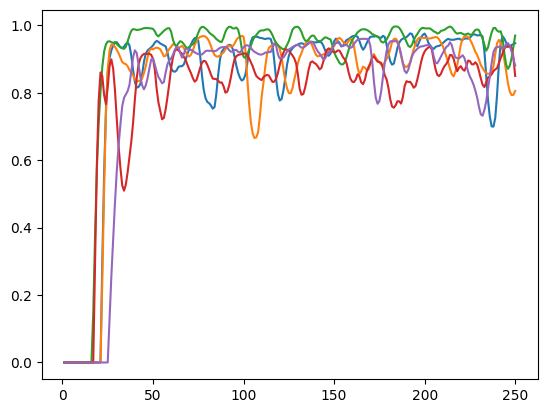

In [47]:
# Cross-validation with R-squared tracking
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores, mae_scores, r2_scores = [], [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    train_dataset = SpectraDataset(X_train, y_train)
    test_dataset = SpectraDataset(X_test, y_test)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = Net(input_size=X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    r2_tracking = train_model_with_r2_tracking(model, criterion, optimizer, train_loader, test_loader, num_epochs=250)
    predictions, true_labels = evaluate_model(model, test_loader)

    mse = mean_squared_error(true_labels, predictions)
    mae = mean_absolute_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)

    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    
    # Plot R-squared tracking for this fold
    r2_tracking_clipped = np.clip(r2_tracking, 0, None)  # Ensure R-squared values are non-negative
    plt.plot(range(1, 251), r2_tracking_clipped, label=f'Fold {len(mse_scores)}')

print(f"Cross-Validated MSE: {np.mean(mse_scores)} ± {np.std(mse_scores)}")
print(f"Cross-Validated MAE: {np.mean(mae_scores)} ± {np.std(mae_scores)}")
print(f"Cross-Validated R^2: {np.mean(r2_scores)} ± {np.std(r2_scores)}")

# Importance
Feature Importance Calculation:

extract the weights of the first fully connected layer (fc1) from the trained model and calculate feature importance by summing the absolute values of the weights across all neurons. The features are then sorted by their importance in descending order.

Peak Detection in Example Spectrum:

An example spectrum is selected from the trimmed data for peak detection.
Peaks in the spectrum are identified using the find_peaks function with a specified height threshold.
Detected peaks and their properties are printed and plotted, highlighting their positions on the spectrum.


Peak Importance Calculation:

The importance of each detected peak is computed by summing the feature importances within a specified range around each peak.
Peaks are then sorted by their calculated importance.

Detected Peaks: [ 26  31  73 155 351 366 393 427 441 449 575 651]


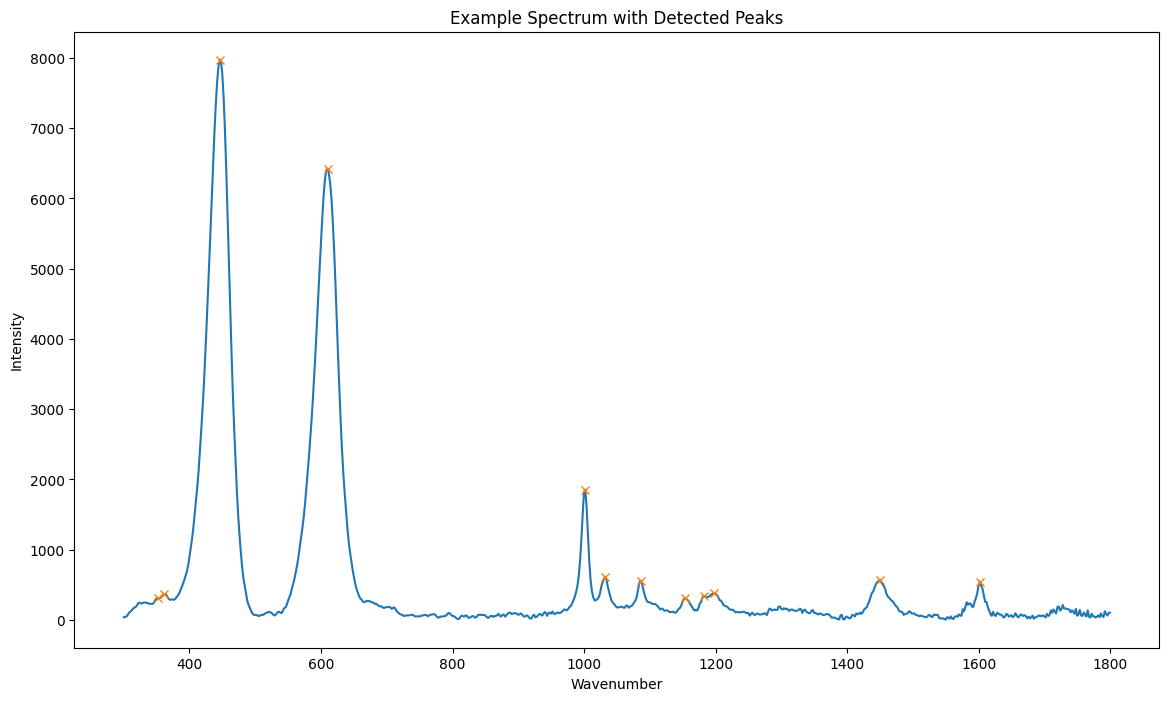

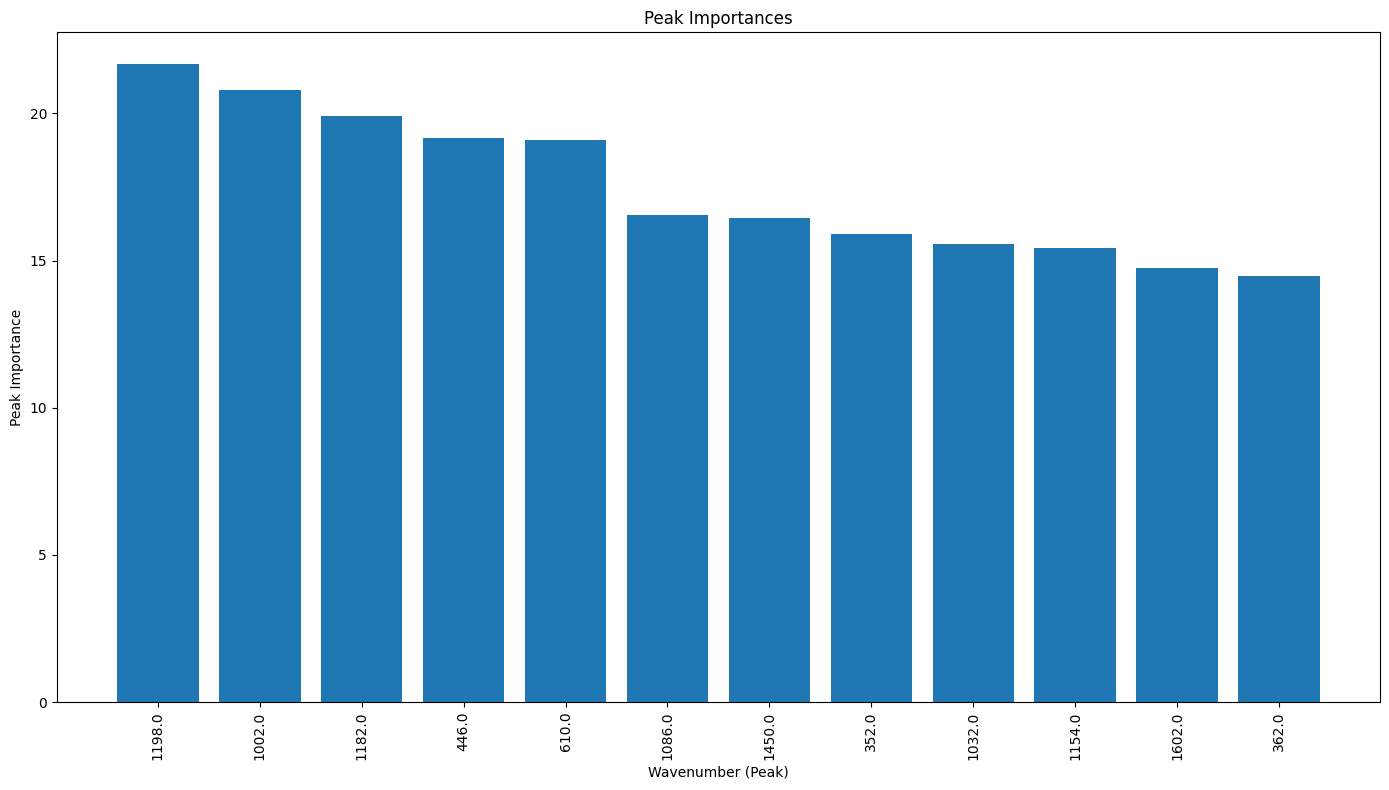

In [50]:
# # Plot R-squared tracking
# plt.xlabel('Epochs')
# plt.ylabel('R-squared')
# plt.title('R-squared vs. Epochs')
# plt.legend()
# plt.show()

# Feature importance
weights = model.fc1.weight.data.numpy()
feature_importance = np.sum(np.abs(weights), axis=0)
indices = np.argsort(feature_importance)[::-1]

# Example Spectrum for Peak Detection
example_spectrum = data_trimmed[0]  # Adjust as needed

# Identify Peaks with adjusted parameters
peaks, properties = find_peaks(example_spectrum, height=300)  # Adjust height and distance parameters as needed

print(f"Detected Peaks: {peaks}")

# Plot the example spectrum with detected peaks
plt.figure(figsize=(14, 8))
plt.plot(wavenumbers_trimmed, example_spectrum)
plt.plot(wavenumbers_trimmed[peaks], example_spectrum[peaks], "x")
plt.xlabel('Wavenumber')
plt.ylabel('Intensity')
plt.title('Example Spectrum with Detected Peaks')
plt.show()

# Compute Feature Importance for Peaks
peak_importances = []

for peak in peaks:
    # Define a range around the peak (you may need to adjust the range width)
    peak_range = range(max(0, peak-2), min(len(feature_importance), peak+3))
    
    # Compute the importance for the peak as the sum of importances within the peak range
    peak_importance = np.sum(feature_importance[list(peak_range)])
    peak_importances.append((wavenumbers_trimmed[peak], peak_importance))

# Sort peaks by their importance
peak_importances.sort(key=lambda x: x[1], reverse=True)

# Extract wavenumbers and importances for plotting
if peak_importances:
    peak_wavenumbers, peak_importance_values = zip(*peak_importances)

    # Plot the peak importances
    plt.figure(figsize=(14, 8))
    plt.bar(range(len(peak_wavenumbers)), peak_importance_values, align='center')
    plt.xticks(range(len(peak_wavenumbers)), peak_wavenumbers, rotation=90)
    plt.xlabel('Wavenumber (Peak)')
    plt.ylabel('Peak Importance')
    plt.title('Peak Importances')
    plt.tight_layout()
    plt.show()
else:
    print("No peaks detected or processed.")


# Final Model Evaluation:

The model is set to evaluation mode.
Predictions are made on the test set (X_test), and the R-squared (R²) score is calculated and printed to assess the model's performance.
T
Prediction Function for Unknown Samples:

A function predict_concentration_for_unknown_samples is defined to predict the concentration for an unknown sample given its filename.
The function reads the spectrum from the specified file, trims and normalizes it similarly to the training data, and applies the same scaling transformation.

The model predicts the concentration, which is printed along with the filename.
The Mean Squared Error (MSE) and Mean Absolute Error (MAE) between the predicted and true values are calculated and printed, providing a quantitative measure of prediction accuracy for the unknown sample.


In [49]:
# Final evaluation on a separate test set
model.eval()
predictions = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
r2 = r2_score(y_test, predictions)
print(f"R^2 on test set: {r2}")

# Dictionary containing true values for the unknown samples
true_values = {
    'test-file-20.dpt': 20.0  # Replace with actual values
}

# Prediction for an unknown sample
def predict_concentration_for_unknown_samples(unknown_sample_filename):
    print(f'File name: {unknown_sample_filename}')
    unknown_sample_filepath = os.path.join('C:\\Users\\baubl\\OneDrive\\Stalinis kompiuteris\\Nuova cartella\\test', unknown_sample_filename)
    unknown_spectrum = pd.read_csv(unknown_sample_filepath, delimiter=',', header=None)
    index_max_1800 = np.where(unknown_spectrum[0] <= max_wavenumber)[0][-1]
    data_trimmed_unknown = unknown_spectrum[1].values[:index_max_1800 + 1]
    normalized_unknown_spectrum = data_trimmed_unknown / np.sum(data_trimmed_unknown)
    normalized_unknown_spectrum = scaler.transform([normalized_unknown_spectrum])  # Apply same scaling
    normalized_unknown_spectrum = torch.tensor(normalized_unknown_spectrum, dtype=torch.float32)

    predicted_percentage = model(normalized_unknown_spectrum).item()
    print(f'Predicted Percentage For Green Pigment: {predicted_percentage}')
    
    # Calculate MSE and MAE for the prediction
    true_value = true_values[unknown_sample_filename]
    mse_value = mean_squared_error([true_value], [predicted_percentage])
    mae_value = mean_absolute_error([true_value], [predicted_percentage])
    print(f'MSE for {unknown_sample_filename}: {mse_value}')
    print(f'MAE for {unknown_sample_filename}: {mae_value}')

# Predict and print MSE and MAE values for each file
predict_concentration_for_unknown_samples('test-file-20.dpt')

R^2 on test set: 0.8807215716288164
File name: test-file-20.dpt
Predicted Percentage For Green Pigment: 19.447505950927734
MSE for test-file-20.dpt: 0.30524967426026706
MAE for test-file-20.dpt: 0.5524940490722656
